This notebook is where satellite images are explored, cleaned and collected.



In [1]:
# Install rasterio
!pip install rasterio

     |████████████████████████████████| 18.3MB 235kB/s 


In [ ]:
#Importing various modules
import rasterio as rio
from rasterio import plot
import matplotlib.pyplot as plt
from rasterio.plot import show
from IPython.display import Image

In [ ]:
# Paths to get blue, green and red bands for a satellite image
bpath = 'http://landsat-pds.s3.amazonaws.com/c1/L8/048/026/LC08_L1TP_048026_20201024_20201106_01_T1/LC08_L1TP_048026_20201024_20201106_01_T1_B2.TIF'
gpath = 'http://landsat-pds.s3.amazonaws.com/c1/L8/048/026/LC08_L1TP_048026_20201024_20201106_01_T1/LC08_L1TP_048026_20201024_20201106_01_T1_B3.TIF'
rpath = 'http://landsat-pds.s3.amazonaws.com/c1/L8/048/026/LC08_L1TP_048026_20201024_20201106_01_T1/LC08_L1TP_048026_20201024_20201106_01_T1_B4.TIF'

In [ ]:
# Opens the blue band image
src_image = rio.open(bpath)

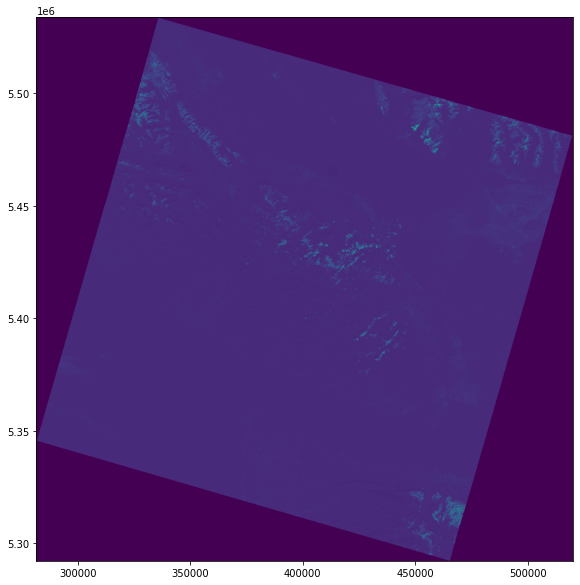

In [ ]:
# Plots the satellite image
fig, ax = plt.subplots(1, figsize=(12, 10))
show(src_image, ax=ax)
plt.show()

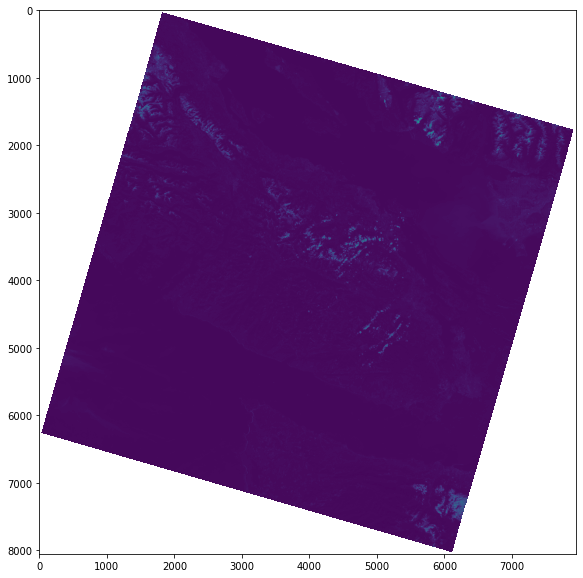

In [ ]:
# Removes the nan (gets rid of pixels that aren't part of the image)
src_image_array[src_image_array==0] = np.nan
fig, ax = plt.subplots(1, figsize=(12, 10))
show(src_image_array, ax=ax)
plt.show()

In [ ]:
# Makes an image from all three bands
red = rio.open(rpath)
green = rio.open(gpath)
blue = rio.open(bpath)

In [ ]:
# Create an RGB image and saves it
with rio.open('RGB.tiff','w',driver='Gtiff', width=red.width, height=red.height,count=3,crs=red.crs,transform=red.transform, dtype=red.dtypes[0]) as rgb:
  rgb.write(blue.read(1),1)
  rgb.write(green.read(1),2)
  rgb.write(red.read(1),3)
  rgb.close()

In [ ]:
# Opens RGB image
rgb_image = rasterio_open('/content/RGB.tiff')

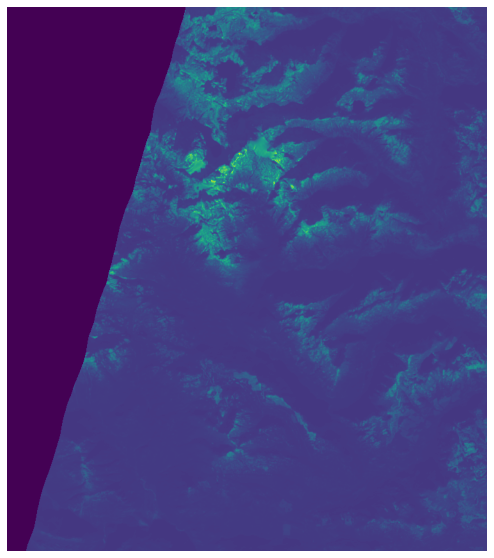

In [ ]:
# Plots a small portion of the RGB image
window = rio.windows.Window(1200, 1200, 750, 850)
subset = rgb_image.read(1, window=window)
fig, ax = plt.subplots(1, figsize=(12, 10))
show(subset, ax=ax)
ax.set_axis_off()
plt.show()

In [ ]:
# Installs earth-engine Python API
!pip install earthengine-api 

In [3]:
# Authenticate earth-engine (Need an account)
!earthengine authenticate 

Instructions for updating:
non-resource variables are not supported in the long term
Running command using Cloud API.  Set --no-use_cloud_api to go back to using the API

To authorize access needed by Earth Engine, open the following URL in a web browser and follow the instructions. If the web browser does not start automatically, please manually browse the URL below.

    https://accounts.google.com/o/oauth2/auth?client_id=517222506229-vsmmajv00ul0bs7p89v5m89qs8eb9359.apps.googleusercontent.com&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fearthengine+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdevstorage.full_control&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&response_type=code&code_challenge=1km3lE0JXWGL8SaPVHrR2DurD-QpgTvJwJEManICIIQ&code_challenge_method=S256

The authorization workflow will generate a code, which you should paste in the box below. 
Enter verification code: 4/1AY0e-g5ha_kfZQTHtaz_M2uOHSb-Ehq4hYjSg0i2HsMsEeZCpdH0NQz4plI

Successfully saved authorization token

In [4]:
# Imports folium
import folium

# Define the URL format used for Earth Engine generated map tiles.
EE_TILES = 'https://earthengine.googleapis.com/map/{mapid}/{{z}}/{{x}}/{{y}}?token={token}'

print('Folium version: ' + folium.__version__)

Folium version: 0.8.3


In [5]:
# Import earth engine and initialize it
import ee
ee.Initialize()

In [7]:
# Use these bands for prediction.
bands = ['B2', 'B3', 'B4'];

# Load a Landsat 8 image to be used for prediction.
image = ee.Image('LC08_L1TP_048026_20201024_20201106_01_T1')\
          .select(bands)

In [6]:
# Gets a map of Seattle using folium
seattle_map = folium.Map(location=[47.5, 239], zoom_start=8)
seattle_map

In [6]:
# Choses a collection of satellite images
landsat = ee.ImageCollection("LANDSAT/LC08/C01/T1_SR")

In [7]:
# Sets the area of interest for Seattion
seattle_AOI = ee.Geometry.Rectangle([237, 46.75, 
                                   238.5, 48])

In [8]:
# From the collection of satellite images, only choses images in the seattle area from Jan-May of 2020
# where cloud cover is less than 5% to make a new collection
landsat_AOI = landsat.filterBounds(seattle_AOI).filterDate('2020-01-01', '2020-5-31').filterMetadata('CLOUD_COVER', 'less_than', 5)

In [9]:
# Gets the least cloudy satellite image
least_cloudy = ee.Image(landsat_AOI.sort('CLOUD_COVER').first())

In [10]:
# Converts the landsat_AOI collection to a lsit
collectionList = landsat_AOI.toList(landsat_AOI.size())

In [ ]:
# Prints the percent cloud cover for every image in the list
for i in range(len(collectionList)):
  image = ee.Image(collectionList.get(i))
  print(image.get('CLOUD_COVER').getInfo())

In [14]:
# prints the total number of images in the image collection
print('Total number:', landsat_AOI.size().getInfo())

Total number: 11


In [14]:
# Displays the 6th image in the image collection
parameters = {'min': 0,
              'max': 1000,
              'dimensions': 512,
              'bands': ['B4', 'B3', 'B2'],
              'region': seattle_AOI}
             

Image(url = ee.Image(collectionList.get(5)).getThumbUrl(parameters))

In [15]:
# From all the images in the image collection, creates a new image where 
# overlapping pixels are combined by taking the median
mosaic = landsat_AOI.sort('CLOUD_COVER').median();

In [ ]:
# Get the geometry for the mosaic image
mosaic.geometry()

In [17]:
# Displays mosaic
parameters = {'min': 0,
              'max': 1000,
              'dimensions': 512,
              'bands': ['B4', 'B3', 'B2'],
              'region': seattle_AOI}
             

Image(url = mosaic.getThumbUrl(parameters))

In [18]:
# Sets a small area of interest
small_AOI = ee.Geometry.Rectangle([237, 46.75, 
                                   238.5, 46.91])

In [19]:
# Prints out the smaller area of interest
parameters = {'min': 0,
              'max': 1000,
              'dimensions': 512,
              'bands': ['B4', 'B3', 'B2'],
              'region': small_AOI}

Image(url = mosaic.getThumbUrl(parameters))

In [20]:
# Sets another small area of interest and displays it
small_AOI = ee.Geometry.Rectangle([237.63, 47.53, 
                                   237.65, 47.55])
parameters = {'min': 0,
              'max': 1000,
              'dimensions': 200,
              'bands': ['B4', 'B3', 'B2'],
              'region': small_AOI}

Image(url = mosaic.getThumbUrl(parameters))

In [280]:
# saves the smaller image as small_image
small_image = mosaic.clip(small_AOI)

In [ ]:
small_image.getInfo()

In [88]:
# Saves the image to Google drive
task = ee.batch.Export.image.toDrive(
            image = mosaic,
            folder = 'Seattle',
            fileNamePrefix = 'full_image',
            scale=10)
task.start()
print('saved')

saved


Visualization
(This is currently not working, so you can skip this section)

In [ ]:
!pip install geetools

In [ ]:
!pip install ipygee

In [120]:
import geetools
import ipygee as ui

In [ ]:
Map = ui.Map()

In [128]:
Map.addLayer(mosaic)
Map.show()

Map(center=[0, 0], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_out_text'…

can't center object because it is unbounded


Avoiding google drive 
(This is also not currently working, so you can skip)

In [48]:
band_arrs = mosaic.clip(small_AOI).select(['B1', 'B2', 'B3'])

In [ ]:
band_arrs.getInfo()

In [34]:
import numpy as np

In [47]:
band_arr_b2.getInfo()

# Loops to get clips of satellite images which are saved onto Google Drive



In [72]:
# Creates an empty shapes list and sets counter to 0
shapes = list()
counter = 0

In [64]:
# Creates smaller tiles of the larger images and saves them onto Google drive
for i in range(0,75):
  for j in range(0,62):
    aoi = ee.Geometry.Rectangle([237+i*.02, 46.75+j*.02, 
                                   237+i*.02+.02, 46.75+j*.02+.02])
    small_image = mosaic.clip(aoi)
    task = ee.batch.Export.image.toDrive(
            image = small_image,
            folder = 'seattle2020',
            fileNamePrefix = 'image' + str(counter),
            scale=10)
    task.start()
    counter+=1


In [ ]:
counter

In [ ]:
#shapes[1].union(shapes[0])

In [ ]:
#seattle_AOI = ee.Geometry.Rectangle([237, 46.75, 238.5, 48])

In [30]:
# import gdal for image processing
from osgeo import gdal

In [ ]:
# Takes in an image and returns another image with only the RGB bands and 8-bit 
# pixels
translate_options = gdal.TranslateOptions(outputType=gdal.GDT_Byte,
                                          scaleParams=[[]],
                                          bandList=[2,3,4]
                                          )

ds = gdal.Open('/content/drive/MyDrive/test/small_image0-1.tif')
gdal.Translate('/content/drive/MyDrive/test/small_image0_gal.tif', ds, options=translate_options)
ds = None



In [90]:
# A loop to convert all the tiles previously created into images that can be used
# by my model
for i in range(4500):
  ds = gdal.Open('/content/drive/MyDrive/seattle2020/image' + str(i)+ '.tif')
  gdal.Translate('/content/drive/MyDrive/seattle2020_gdal/image' + str(i)+ '.tif', ds, options=translate_options)
  ds = None 


In [ ]:
# displays the image
image = rio.open('/content/drive/MyDrive/Seattle_2020/image2.tif')
fig, ax = plt.subplots(1, figsize=(10, 10))
show(image, ax=ax)
plt.show()

In [305]:
# Gets the image shape
image.shape

(224, 224)

In [ ]:
# gets the pixel data types
image.dtypes

('uint8', 'uint8', 'uint8')

#  Putting the images into the Model

In [ ]:
# imstall newest version of fastai
pip install fastai --upgrade

In [35]:
# Imports for the model
from fastai.vision.all import *
import fastai
import PIL

In [36]:
import torch
print(fastai.__version__)
print(torch.__version__)

2.1.8
1.7.0+cu101


In [38]:
# Opens the model as learn
learn = load_learner('/content/drive/MyDrive/export.pkl')

In [ ]:
# Opens an image from Google Drive
img = open_image('/content/drive/MyDrive/test/small_image0_gal.tif')

In [ ]:
# Gets image size
img.size()

torch.Size([3, 224, 224])

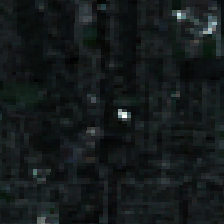

In [ ]:
# Displays image
PIL.Image.open('/content/drive/MyDrive/test/small_image0_gal.tif')

In [40]:
# Creates an empty list in which to put urban areas
urban_areas = list()

In [ ]:
# Loop to input images into model and determine if the image is urban or not
for i in range(100,200):
  a, b, c = learn.predict(PILImage.create('/content/drive/MyDrive/seattle2020_gdal/part_1/image' + str(i)+ '.tif'))
  print(a)
  if a in ['Residential', 'Industrial', 'Highway']:
    urban_areas.append(i)

In [96]:
len(urban_areas)

35